In [1]:
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from side_info_decoding.utils import set_seed, load_data_from_pids

import PSID

seed = 666
set_seed(seed)

In [2]:
class GLM(torch.nn.Module):    
    def __init__(self, n_c, n_t, n_r):
        super(GLM, self).__init__()
        self.U = torch.nn.Parameter(torch.randn(n_c, n_r))
        self.V = torch.nn.Parameter(torch.randn(n_r, n_t))
        self.b = torch.nn.Parameter(torch.randn(1, n_c, 1))
        
    def forward(self, y):
        self.beta = torch.einsum("cr,rt->ct", self.U, self.V)
        x_pred = self.beta[None,:,:] * y + self.b
        return x_pred
    
def train_glm(
    X, 
    Y, 
    train,
    test,
    n_r = 10,
    learning_rate=1e-3,
    n_epochs=10000,
    ):
    
    _, n_c, n_t = X.shape
    glm = GLM(n_c, n_t, n_r)
    optimizer = torch.optim.Adam(glm.parameters(), lr=learning_rate)
    # criterion = torch.nn.PoissonNLLLoss(full=True)
    criterion = torch.nn.PoissonNLLLoss()
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)[:,None,:]
    train_x, test_x = X[train], X[test]
    train_y, test_y = Y[train], Y[test]
    
    losses = []
    for epoch in tqdm(range(n_epochs), desc="Train GLM:"):
        optimizer.zero_grad()
        x_pred = glm(train_y)
        loss = criterion(x_pred, train_x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return glm, losses

In [3]:
def time_bin_wise_metrics(y_true, y_pred):
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    corr = pearsonr(y_true.flatten(), y_pred.flatten())[0]
    return r2, corr

def continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False):
    penalty = [0.001, 0.01, 1, 10, 100, 1000]
    
    train_K, test_K = len(train_X), len(test_X)
    _, C, T = train_X.shape
    if time_independent:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, C))
        train_Y = train_Y.reshape((-1))
        test_Y = test_Y.reshape((-1))
        print("time-independent:")
    else:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, T*C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, T*C))
        print("time-dependent:")
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    print(decoder.best_params_)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    if time_independent:
        r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    else:
        r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    print(f"r2: {r2:.3f} corr: {corr:.3f}")
    
    return pred_Y, [r2, corr]

def sliding_window_over_time(data, half_window_size=3):
    
    window_size = 2*half_window_size + 1
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - 2*half_window_size, window_size
        ))
        for t in range(n_t_bins - 2*half_window_size):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t + d]
            data_window[:,:,t] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        max_len = n_t_bins - 2*half_window_size
        data_window = np.zeros((n_trials, max_len, window_size))
        for t in range(max_len):
            data_window[:,t] = data[:,t:t+window_size]
        data_window = data_window[:,:,half_window_size]
    return data_window

def sliding_window_decoder(train_X, train_Y, test_X, test_Y):
    penalty = [0.001, 0.01, 1, 10, 100, 1000]
    
    train_K, C, T, L = train_X.shape
    test_K, _, _, _ = test_X.shape
    
    train_X = train_X.transpose(0,1,-1,2).reshape(train_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    test_X = test_X.transpose(0,1,-1,2).reshape(test_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    train_Y = train_Y.reshape((-1))
    test_Y = test_Y.reshape((-1))
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    print(decoder.best_params_)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    print("sliding-window:")
    print(f"r2: {r2:.3f} corr: {corr:.3f}")
    
    return pred_Y, [r2, corr]

### Load Data

In [4]:
pids = ["dab512bd-a02d-4c1f-8dbc-9155a163efc0"]

In [5]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="po",
    behavior="paw_speed",
    data_type="all_ks",
    n_t_bins = 50,
    t_before = .2,
    t_after = .8,
    normalize_input=False
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)
prior for this session is not found.
found 367 trials from 17.56 to 2310.24 sec.
found 163 Kilosort units in region po


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 1154.67it/s]


In [6]:
pid = pids[0]
X, Y = X_dict[pid], Y_dict[pid]
K, C, T = X.shape
smooth_X = np.array(
    [[gaussian_filter1d(X[k, c, :], 4) for c in range(C)] for k in range(K)]
)
smooth_Y = np.array([gaussian_filter1d(Y[k, :], 4) for k in range(K)])
print(X.shape)
print(Y.shape)

(367, 159, 50)
(367, 50)


In [7]:
norm_Y = smooth_Y / smooth_Y.max()

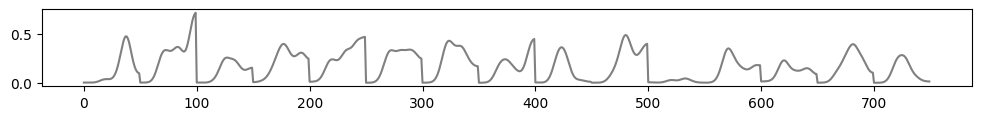

In [8]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[10:10+15].flatten(), c="gray")
plt.show()

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
for train, test in kf.split(X):
    pass

#### Baseline

In [10]:
train_X, test_X = smooth_X[train], smooth_X[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
{'alpha': 100}
r2: 0.445 corr: 0.669
time-dependent:
{'alpha': 1000}
r2: 0.472 corr: 0.693


In [11]:
window_X = sliding_window_over_time(smooth_X, half_window_size=5)
window_Y = sliding_window_over_time(norm_Y, half_window_size=5)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
print(window_X.shape)

y_pred, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

(367, 159, 40, 11)
{'alpha': 1000}
sliding-window:
r2: 0.465 corr: 0.683


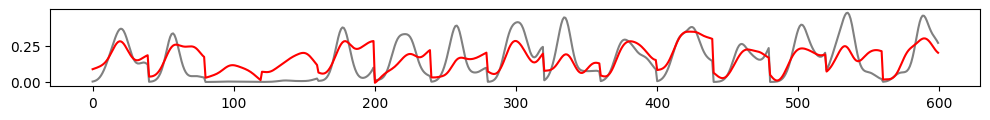

In [12]:
plt.figure(figsize=(12,1))
plt.plot(test_Y[10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

### PSID

In [13]:
xTrain = [smooth_X[k].T for k in train]
xTest = [smooth_X[k].T for k in test]
yTrain = [norm_Y[k].reshape(-1,1) for k in train]
yTest = [norm_Y[k].reshape(-1,1) for k in test]
xAll = [smooth_X[k].T for k in range(K)]

In [14]:
from PSID.evaluation import evalPrediction

In [15]:
idSys = PSID.PSID(xTrain, yTrain, nx=20, n1=10, i=10)

In [16]:
yPred, xPred, zPred = [], [], []
for k in range(K):
    y, x, z = idSys.predict(xAll[k])
    yPred.append(y)
    xPred.append(x)
    zPred.append(z)

In [17]:
yPred = np.array(yPred).squeeze()
xPred = np.array(xPred)
zPred = np.array(zPred)

In [18]:
evalPrediction(np.concatenate(yTest), np.concatenate(yPred[test]), 'R2')

array([0.3556528])

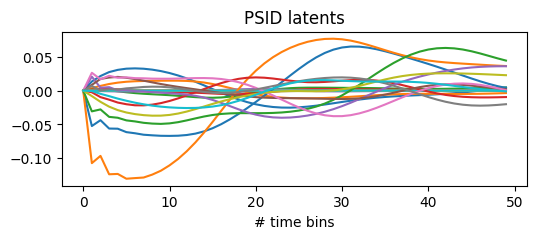

In [19]:
plt.figure(figsize=(6,2))
plt.plot(zPred.mean(0))
plt.title("PSID latents")
plt.xlabel("# time bins")
plt.show()

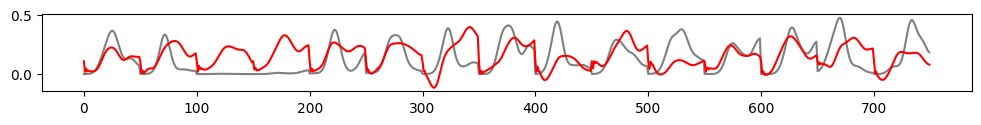

In [20]:
yTest = np.array(yTest).squeeze()
plt.figure(figsize=(12,1))
plt.plot(yTest[10:10+15].flatten(), c="gray")
plt.plot(yPred[10:10+15].flatten(), c="r")
plt.show()

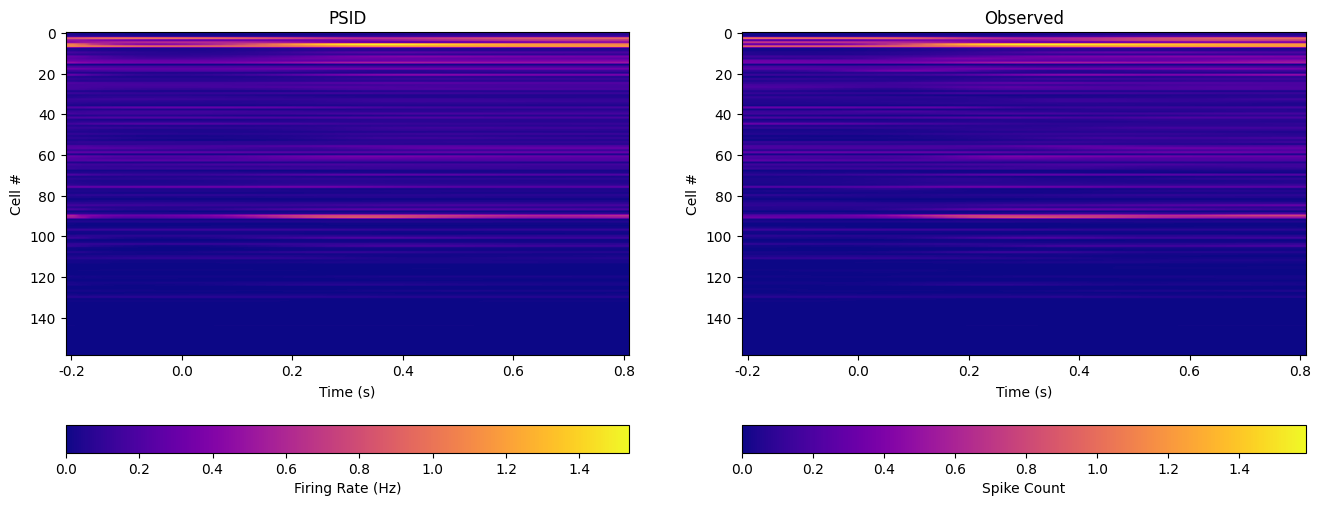

In [21]:
xTest = np.array(xTest)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
im1 = ax1.imshow(xPred.mean(0).T, aspect="auto", cmap=plt.cm.plasma)
ax1.set_xticks(np.linspace(0, 49, 6), ['%.1f'%i for i in np.linspace(-.2, .8, 6)])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Cell #')
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', label='Firing Rate (Hz)')
ax1.set_title('PSID')

im2 = ax2.imshow(xTest.mean(0).T, aspect="auto", cmap=plt.cm.plasma)
ax2.set_xticks(np.linspace(0, 49, 6), ['%.1f'%i for i in np.linspace(-.2, .8, 6)])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Cell #')
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', label='Spike Count')
ax2.set_title('Observed');

In [22]:
evalPrediction(np.concatenate(xTest).flatten(), np.concatenate(xPred[test]).flatten(), 'R2')

array([0.7583127])

In [23]:
zPred = zPred.transpose(0,-1,1)

train_X, test_X = zPred[train], zPred[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
{'alpha': 0.01}
r2: 0.360 corr: 0.614
time-dependent:
{'alpha': 10}
r2: 0.409 corr: 0.640


In [24]:
window_X = sliding_window_over_time(zPred, half_window_size=5)
window_Y = sliding_window_over_time(norm_Y, half_window_size=5)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
print(window_X.shape)

y_pred, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

(367, 20, 40, 11)
{'alpha': 0.001}
sliding-window:
r2: 0.372 corr: 0.631


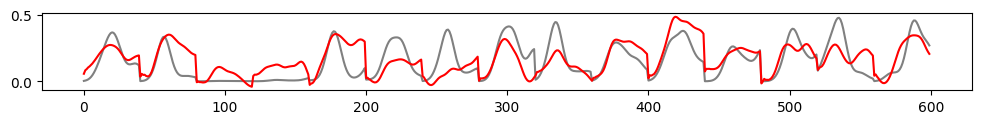

In [25]:
plt.figure(figsize=(12,1))
plt.plot(test_Y[10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

In [26]:
xPred = xPred.transpose(0,-1,1)

train_X, test_X = xPred[train], xPred[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
{'alpha': 1}
r2: 0.356 corr: 0.612
time-dependent:
{'alpha': 100}
r2: 0.504 corr: 0.710


In [27]:
window_X = sliding_window_over_time(xPred, half_window_size=5)
window_Y = sliding_window_over_time(norm_Y, half_window_size=5)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
print(window_X.shape)

y_pred, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

(367, 159, 40, 11)
{'alpha': 0.001}
sliding-window:
r2: 0.376 corr: 0.636


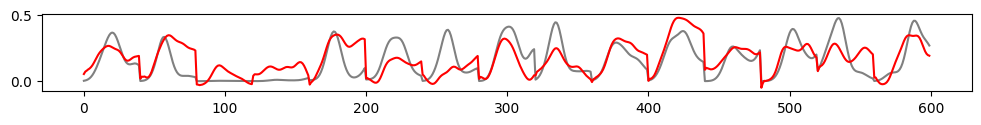

In [28]:
plt.figure(figsize=(12,1))
plt.plot(test_Y[10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

### CEBRA

### GLM Subspace

In [29]:
R = 15

glm, losses = train_glm(
    X = smooth_X,
    Y = norm_Y, 
    train = train,
    test = test,
    n_r = R,
    learning_rate = 1e-2,
    n_epochs = 10000
)

Train GLM:: 100%|█████████████████████████| 10000/10000 [03:17<00:00, 50.62it/s]


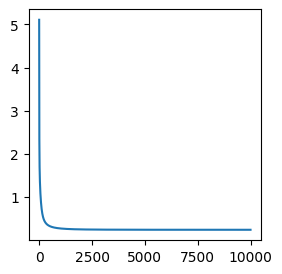

In [30]:
plt.figure(figsize=(3,3))
plt.plot(losses);

In [31]:
supervised_subspace = glm.U.detach().numpy()
subspace_weights = glm.V.detach().numpy()

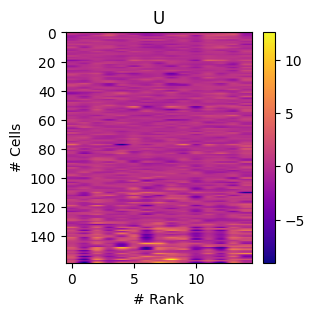

In [32]:
plt.figure(figsize=(3,3))
plt.imshow(supervised_subspace, aspect="auto", cmap="plasma")
plt.title("U")
plt.xlabel("# Rank")
plt.ylabel("# Cells")
plt.colorbar()
plt.show()

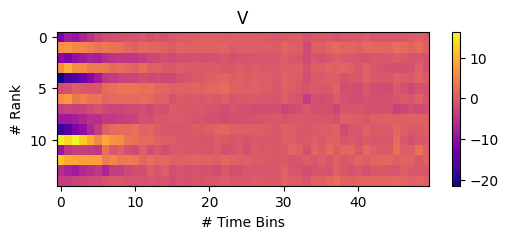

In [33]:
plt.figure(figsize=(6,2))
plt.imshow(subspace_weights, aspect="auto", cmap="plasma")
plt.title("V")
plt.xlabel("# Time Bins")
plt.ylabel("# Rank")
plt.colorbar()
plt.show()

In [34]:
all_proj = smooth_X.transpose(0,-1,1) @ supervised_subspace
weighted_proj = all_proj * subspace_weights.T
smooth_proj = np.array(
    [[gaussian_filter1d(weighted_proj[k, :, r], 4) for r in range(R)] for k in range(K)]
)
print(smooth_proj.shape)

(367, 15, 50)


In [35]:
from sklearn.preprocessing import normalize
smooth_proj = normalize(smooth_proj.reshape(-1, R*T)).reshape(-1, R, T)

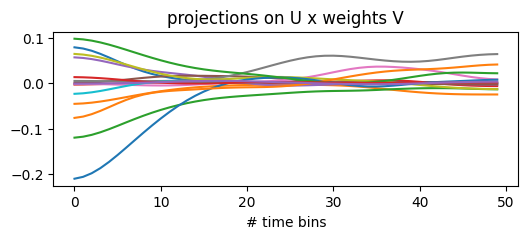

In [36]:
from sklearn.preprocessing import normalize

plt.figure(figsize=(6,2))
plt.plot(smooth_proj.mean(0).T)
plt.title("projections on U x weights V")
plt.xlabel("# time bins")
plt.show()

In [37]:
train_X, test_X = smooth_proj[train], smooth_proj[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

_, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
{'alpha': 0.01}
r2: 0.317 corr: 0.565
time-dependent:
{'alpha': 1}
r2: 0.382 corr: 0.618


In [38]:
window_X = sliding_window_over_time(smooth_proj, half_window_size=5)
window_Y = sliding_window_over_time(norm_Y, half_window_size=5)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
print(window_X.shape)

y_pred, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

(367, 15, 40, 11)
{'alpha': 0.001}
sliding-window:
r2: 0.379 corr: 0.615


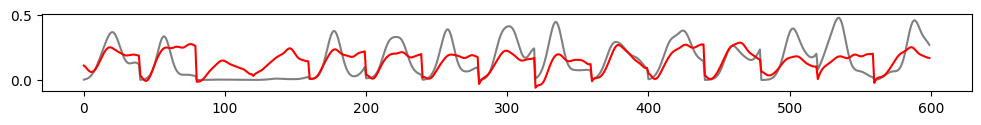

In [39]:
plt.figure(figsize=(12,1))
plt.plot(test_Y[10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

In [40]:
train_X, test_X = smooth_X[train], smooth_X[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

pred_Y, _ = continuous_decoder(train_X, train_Y, smooth_X, norm_Y, time_independent=False)

time-dependent:
{'alpha': 1000}
r2: 0.523 corr: 0.737


In [41]:
inferred_rates = glm(torch.tensor(pred_Y)[:,None,:]).exp().detach().numpy()
smooth_rates = np.array(
    [[gaussian_filter1d(inferred_rates[k, c, :], 4) for c in range(C)] for k in range(K)]
)

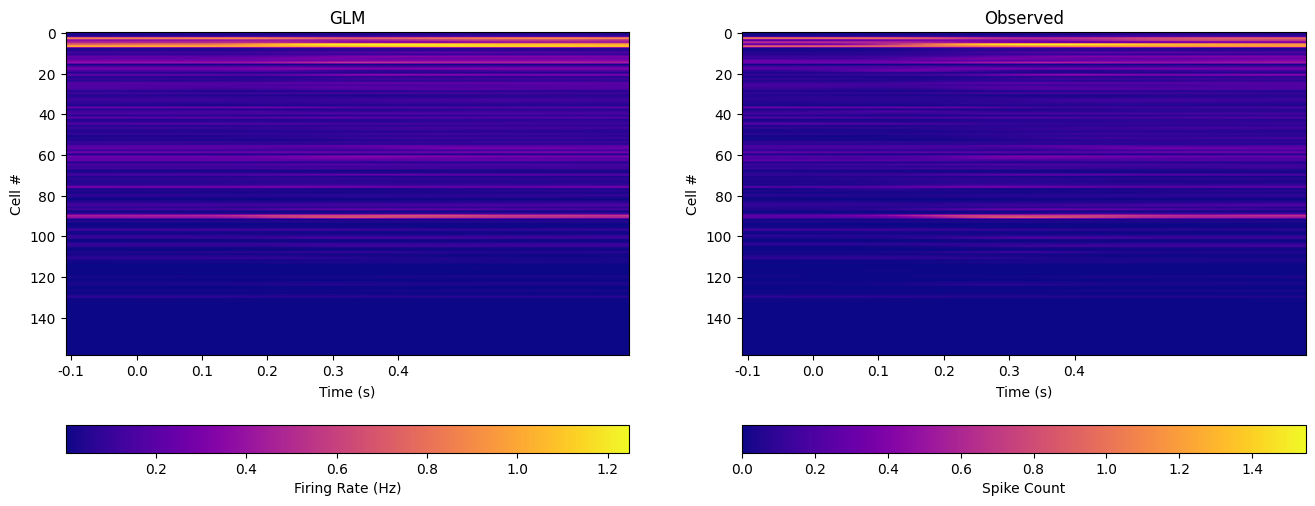

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
im1 = ax1.imshow(inferred_rates.mean(0), aspect="auto", cmap=plt.cm.plasma)
ax1.set_xticks(np.linspace(0, 29, 6), ['%.1f'%i for i in np.linspace(-.1, .4, 6)])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Cell #')
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', label='Firing Rate (Hz)')
ax1.set_title('GLM')

im2 = ax2.imshow(smooth_X.mean(0), aspect="auto", cmap=plt.cm.plasma)
ax2.set_xticks(np.linspace(0, 29, 6), ['%.1f'%i for i in np.linspace(-.1, .4, 6)])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Cell #')
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', label='Spike Count')
ax2.set_title('Observed');

In [43]:
evalPrediction(np.concatenate(smooth_X[test]).flatten(), np.concatenate(inferred_rates[test]).flatten(), 'R2')

array([0.55667066])

In [44]:
train_X, test_X = smooth_rates[train], smooth_rates[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

_, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
{'alpha': 1}
r2: 0.484 corr: 0.700
time-dependent:
{'alpha': 0.01}
r2: 0.480 corr: 0.701


In [45]:
window_X = sliding_window_over_time(smooth_rates, half_window_size=5)
window_Y = sliding_window_over_time(norm_Y, half_window_size=5)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
print(window_X.shape)

y_pred, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

(367, 159, 40, 11)
{'alpha': 0.001}
sliding-window:
r2: 0.503 corr: 0.712


### Low-Rank Subspace

In [46]:
class ReducedRankRegression(torch.nn.Module):    
    def __init__(self, n_c, n_t, n_r):
        super(ReducedRankRegression, self).__init__()
        self.U = torch.nn.Parameter(torch.randn(n_c, n_r))
        self.V = torch.nn.Parameter(torch.randn(n_r, n_t))
        self.b = torch.nn.Parameter(torch.randn(1,))
        
    def forward(self, x):
        self.beta = self.U @ self.V
        out = torch.einsum("ct,kct->kt", self.beta, x)
        out += self.b
        return out
    
def train_rrr(
    X, 
    Y, 
    train,
    test,
    n_r = 10,
    learning_rate=1e-3,
    n_epochs=10000,
    ):
    
    _, n_c, n_t = X.shape
    rrr = ReducedRankRegression(n_c, n_t, n_r)
    optimizer = torch.optim.Adam(rrr.parameters(), lr=learning_rate, weight_decay=1e-3)
    criterion = torch.nn.MSELoss()
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    train_x, test_x = X[train], X[test]
    train_y, test_y = Y[train], Y[test]
    
    losses = []
    for epoch in tqdm(range(n_epochs), desc="Train RRR:"):
        optimizer.zero_grad()
        y_pred = rrr(train_x)
        loss = criterion(y_pred, train_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return rrr, losses

In [47]:
R = 15

rrr, losses = train_rrr(
    X = smooth_X,
    Y = norm_Y, 
    train = train,
    test = test,
    n_r = R,
    learning_rate = 5e-3,
    n_epochs = 10000
)

Train RRR:: 100%|█████████████████████████| 10000/10000 [02:00<00:00, 83.11it/s]


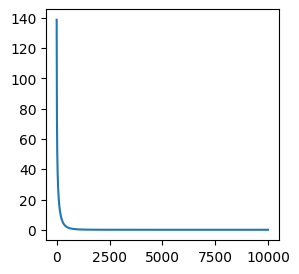

In [48]:
plt.figure(figsize=(3,3))
plt.plot(losses);

In [49]:
with torch.no_grad():
    y_pred = rrr(torch.tensor(smooth_X[test])).detach().numpy()
time_bin_wise_metrics(norm_Y[test], y_pred)

(0.49676524137294553, 0.7061745975775731)

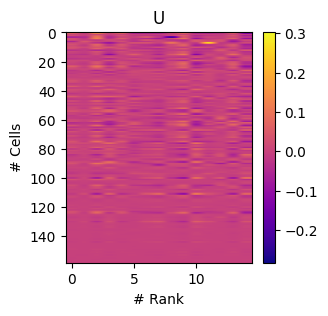

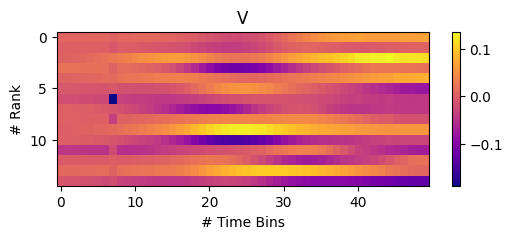

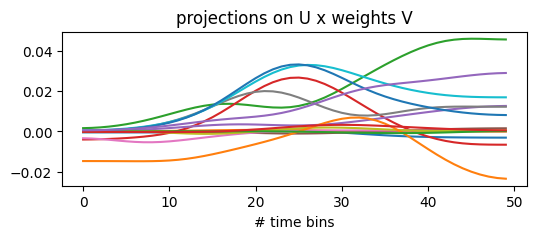

time-independent:
{'alpha': 0.01}
r2: 0.480 corr: 0.701
time-dependent:
{'alpha': 1}
r2: 0.492 corr: 0.703


In [50]:
supervised_subspace = rrr.U.detach().numpy()
subspace_weights = rrr.V.detach().numpy()

plt.figure(figsize=(3,3))
plt.imshow(supervised_subspace, aspect="auto", cmap="plasma")
plt.title("U")
plt.xlabel("# Rank")
plt.ylabel("# Cells")
plt.colorbar()
plt.show()

plt.figure(figsize=(6,2))
plt.imshow(subspace_weights, aspect="auto", cmap="plasma")
plt.title("V")
plt.xlabel("# Time Bins")
plt.ylabel("# Rank")
plt.colorbar()
plt.show()

all_proj = smooth_X.transpose(0,-1,1) @ supervised_subspace
weighted_proj = all_proj * subspace_weights.T
smooth_proj = np.array(
    [[gaussian_filter1d(weighted_proj[k, :, r], 4) for r in range(R)] for k in range(K)]
)

plt.figure(figsize=(6,2))
plt.plot(smooth_proj.mean(0).T)
plt.title("projections on U x weights V")
plt.xlabel("# time bins")
plt.show()

train_X, test_X = smooth_proj[train], smooth_proj[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

_, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
_, metrics = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

In [51]:
window_X = sliding_window_over_time(smooth_proj, half_window_size=5)
window_Y = sliding_window_over_time(norm_Y, half_window_size=5)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
print(window_X.shape)

y_pred, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

(367, 15, 40, 11)
{'alpha': 0.01}
sliding-window:
r2: 0.476 corr: 0.697
